### Prediksi Data Saham

### Menggunakan Long Short Term Memory (LSTM)

In [12]:
# Function LSTM

import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd

%matplotlib inline

def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def dtanh(values): 
    return 1. - values**2

# createst uniform random array w/ values in [a,b) and shape args
def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

class LstmParam:
    def __init__(self, nc, x_dim):    
        self.nc    = nc              #nc: number of cells, banyaknya cell di tiap time step
        self.x_dim = x_dim           #x_dim jumlah features di X, atau time-steps 
        concat_len = x_dim + nc
        
        # weight matrices
        self.wg = rand_arr(-0.1, 0.1, nc, concat_len)
        self.wi = rand_arr(-0.1, 0.1, nc, concat_len) 
        self.wf = rand_arr(-0.1, 0.1, nc, concat_len)
        self.wo = rand_arr(-0.1, 0.1, nc, concat_len)
        
        # bias terms
        self.bg = rand_arr(-0.1, 0.1, nc) 
        self.bi = rand_arr(-0.1, 0.1, nc) 
        self.bf = rand_arr(-0.1, 0.1, nc) 
        self.bo = rand_arr(-0.1, 0.1, nc) 
        
        # diffs (derivative of loss function w.r.t. all parameters)
        self.wg_diff = zeros((nc, concat_len)) 
        self.wi_diff = zeros((nc, concat_len)) 
        self.wf_diff = zeros((nc, concat_len)) 
        self.wo_diff = zeros((nc, concat_len)) 
        self.bg_diff = zeros(nc) 
        self.bi_diff = zeros(nc) 
        self.bf_diff = zeros(nc) 
        self.bo_diff = zeros(nc) 

    def apply_diff(self, alpha = 1):
        self.wg -= alpha*self.wg_diff
        self.wi -= alpha*self.wi_diff
        self.wf -= alpha*self.wf_diff
        self.wo -= alpha*self.wo_diff
        self.bg -= alpha*self.bg_diff
        self.bi -= alpha*self.bi_diff
        self.bf -= alpha*self.bf_diff
        self.bo -= alpha*self.bo_diff
        
        # reset diffs to zero
        self.wg_diff = zeros_like(self.wg)
        self.wi_diff = zeros_like(self.wi) 
        self.wf_diff = zeros_like(self.wf) 
        self.wo_diff = zeros_like(self.wo) 
        self.bg_diff = zeros_like(self.bg)
        self.bi_diff = zeros_like(self.bi) 
        self.bf_diff = zeros_like(self.bf) 
        self.bo_diff = zeros_like(self.bo) 

class LstmState:
    def __init__(self, nc, x_dim):
        self.g = zeros(nc)
        self.i = zeros(nc)
        self.f = zeros(nc)
        self.o = zeros(nc)
        self.s = zeros(nc)
        self.h = zeros(nc)
        self.bottom_diff_h = zeros_like(self.h)
        self.bottom_diff_s = zeros_like(self.s)
    
class LstmNode:
    def __init__(self, lstm_param, lstm_state):
        # store reference to parameters and to activations
        self.state = lstm_state
        self.param = lstm_param
        # non-recurrent input concatenated with recurrent input
        self.xc = None

    def bottom_data_is(self, x, s_prev = None, h_prev = None):
        # if this is the first lstm node in the network
        if s_prev is None: s_prev = zeros_like(self.state.s)
        if h_prev is None: h_prev = zeros_like(self.state.h)
            
        # save data for use in backprop
        self.s_prev = s_prev
        self.h_prev = h_prev

        # concatenate x(t) and h(t-1)
        xc = np.hstack((x,  h_prev))
        self.state.g = tanh(dot(self.param.wg, xc) + self.param.bg)
        self.state.i = Sigmoid(dot(self.param.wi, xc) + self.param.bi)
        self.state.f = Sigmoid(dot(self.param.wf, xc) + self.param.bf)
        self.state.o = Sigmoid(dot(self.param.wo, xc) + self.param.bo)
        self.state.s = self.state.g*self.state.i + s_prev*self.state.f
        self.state.h = self.state.s*self.state.o

        self.xc = xc
    
    def top_diff_is(self, top_diff_h, top_diff_s):
        # notice that top_diff_s is carried along the constant error carousel
        ds = self.state.o*top_diff_h + top_diff_s
        do = self.state.s*top_diff_h
        di = self.state.g*ds
        dg = self.state.i*ds
        df = self.s_prev*ds

        # diffs w.r.t. vector inside sigma / tanh function
        di_input = dSigmoid(self.state.i)*di 
        df_input = dSigmoid(self.state.f)*df 
        do_input = dSigmoid(self.state.o)*do 
        dg_input = dtanh(self.state.g)*dg

        # diffs w.r.t. inputs
        self.param.wi_diff += outer(di_input, self.xc)
        self.param.wf_diff += outer(df_input, self.xc)
        self.param.wo_diff += outer(do_input, self.xc)
        self.param.wg_diff += outer(dg_input, self.xc)
        self.param.bi_diff += di_input
        self.param.bf_diff += df_input       
        self.param.bo_diff += do_input
        self.param.bg_diff += dg_input       

        # compute bottom diff
        dxc  = zeros_like(self.xc)
        dxc += dot(self.param.wi.T, di_input)
        dxc += dot(self.param.wf.T, df_input)
        dxc += dot(self.param.wo.T, do_input)
        dxc += dot(self.param.wg.T, dg_input)

        # save bottom diffs
        self.state.bottom_diff_s = ds * self.state.f
        self.state.bottom_diff_h = dxc[self.param.x_dim:]

class LstmNetwork():
    def __init__(self, lstm_param):
        self.lstm_param = lstm_param
        self.lstm_node_list = []
        
        # input sequence
        self.x_list = []

    def y_list_is(self, y_list, loss_layer):
        
        """
        Updates diffs by setting target sequence 
        with corresponding loss layer. 
        Will *NOT* update parameters.  To update parameters,
        call self.lstm_param.apply_diff()
        """
        
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        
        # first node only gets diffs from label ...
        loss = loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
        diff_h = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
        
        # here s is not affecting loss due to h(t+1), hence we set equal to zero
        diff_s = zeros(self.lstm_param.nc)
        self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
        idx -= 1

        ### ... following nodes also get diffs from next nodes, hence we add diffs to diff_h
        ### we also propagate error along constant error carousel using diff_s
        while idx  >= 0:
            loss   += loss_layer.loss(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h  = loss_layer.bottom_diff(self.lstm_node_list[idx].state.h, y_list[idx])
            diff_h += self.lstm_node_list[idx + 1].state.bottom_diff_h
            diff_s  = self.lstm_node_list[idx + 1].state.bottom_diff_s
            self.lstm_node_list[idx].top_diff_is(diff_h, diff_s)
            idx    -= 1 

        return loss

    def x_list_clear(self):
        self.x_list = []

    def x_list_add(self, x):
        self.x_list.append(x)
        
        if len(self.x_list) > len(self.lstm_node_list):
            # need to add new lstm node, create new state mem
            lstm_state = LstmState(self.lstm_param.nc, self.lstm_param.x_dim)
            self.lstm_node_list.append(LstmNode(self.lstm_param, lstm_state))

        # get index of most recent x input
        idx = len(self.x_list) - 1
        if idx == 0:
            # no recurrent inputs yet
            self.lstm_node_list[idx].bottom_data_is(x)
        else:
            s_prev = self.lstm_node_list[idx - 1].state.s
            h_prev = self.lstm_node_list[idx - 1].state.h
            self.lstm_node_list[idx].bottom_data_is(x, s_prev, h_prev)
            
class LossLayer:
    
    """
    Computes square loss with first element of hidden layer array.
    """
    
    @classmethod
    def loss(self, pred, label):
        return (pred[0] - label) ** 2

    @classmethod
    def bottom_diff(self, pred, label):
        diff = np.zeros_like(pred)
        diff[0] = 2 * (pred[0] - label)
        return diff

In [2]:
# Input Data

np.random.seed(2020)

#Parameters for input data dimension and lstm cell count
    
x       = pickle.load(open("HargaSaham.dat", "rb"))   #Ini data harga saham sebanyak 250 observasi.
xs      = (x-x.min())/(x.max()-x.min())   #Datanya distandardisasikan dulu
N       = xs.shape[0]



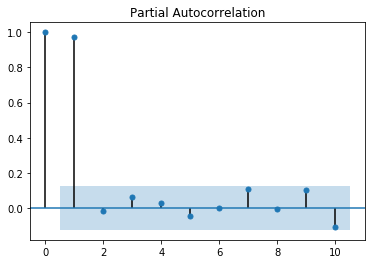

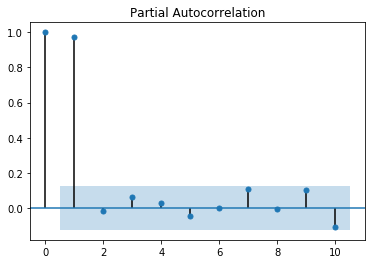

In [3]:
# Cek korelasi lag 1-10

from statsmodels.graphics.tsaplots import plot_pacf
#plot_acf(x, lags=10)
plot_pacf(x, lags=10)

In [4]:
# membuat Time Step / Time-Lag

import pandas as pd

Xs = pd.DataFrame(xs)
n = 3
b = Xs

for i in range(1,n):
  a = Xs.shift(i)
  b = pd.concat([a,b], axis=1)

#dataset = pd.concat([b,Xs],axis=1)
dataset = b
dataset.columns = ['t-2','t-1','t']
print(dataset.head(14))
print(dataset.shape)

         t-2       t-1         t
0        NaN       NaN  0.562912
1        NaN  0.562912  0.573332
2   0.562912  0.573332  0.592352
3   0.573332  0.592352  0.467694
4   0.592352  0.467694  0.409983
5   0.467694  0.409983  0.439758
6   0.409983  0.439758  0.489736
7   0.439758  0.489736  0.437683
8   0.489736  0.437683  0.464447
9   0.437683  0.464447  0.486067
10  0.464447  0.486067  0.503275
11  0.486067  0.503275  0.477026
12  0.503275  0.477026  0.434892
13  0.477026  0.434892  0.390080
(250, 3)


In [5]:
# add new feature, rolling windows

dataset['rm7'] = dataset['t'].rolling(window=7).mean()
dataset['rm3'] = dataset['t'].rolling(window=3).mean()

#data = data[['Datetime', 'rolling_mean', 'Count']]
dataset.head(10)

,t-2,t-1,t,rm7,rm3
0,NaN,NaN,0.562912,NaN,NaN
1,NaN,0.562912,0.573332,NaN,NaN
2,0.562912,0.573332,0.592352,NaN,0.576199
3,0.573332,0.592352,0.467694,NaN,0.544459
4,0.592352,0.467694,0.409983,NaN,0.490010
5,0.467694,0.409983,0.439758,NaN,0.439145
6,0.409983,0.439758,0.489736,0.505110,0.446493
7,0.439758,0.489736,0.437683,0.487220,0.455726
8,0.489736,0.437683,0.464447,0.471665,0.463955
9,0.437683,0.464447,0.486067,0.456481,0.462732


In [6]:
# Drop row with NaN data

dataset.dropna(inplace=True)
print(dataset.shape)
print(dataset.head())
#dataset = np.array(dataset)

(244, 5)
         t-2       t-1         t       rm7       rm3
6   0.409983  0.439758  0.489736  0.505110  0.446493
7   0.439758  0.489736  0.437683  0.487220  0.455726
8   0.489736  0.437683  0.464447  0.471665  0.463955
9   0.437683  0.464447  0.486067  0.456481  0.462732
10  0.464447  0.486067  0.503275  0.461564  0.484596


In [7]:
# Split dataset into x and y

datasetx = dataset.drop('t',1)
datasety = dataset['t']

print(datasetx.head())
print(datasety.head())


         t-2       t-1       rm7       rm3
6   0.409983  0.439758  0.505110  0.446493
7   0.439758  0.489736  0.487220  0.455726
8   0.489736  0.437683  0.471665  0.463955
9   0.437683  0.464447  0.456481  0.462732
10  0.464447  0.486067  0.461564  0.484596
6     0.489736
7     0.437683
8     0.464447
9     0.486067
10    0.503275
Name: t, dtype: float64


In [8]:
# Convert into Array

datasetx = np.array(datasetx)
datasety = np.array(datasety)

In [9]:
# Split data jadi train dan test
# dengan rolling mean()

n_train = round(len(dataset)*0.9) # jumlah data train 90% dan test 10%

x_train = datasetx[:n_train, :]
y_train = datasety[:n_train]
print("x_train = ", x_train.shape)
print("y_train = ", y_train.shape)

x_test = datasetx[n_train:, :]
y_test = datasety[n_train:]
print("x_test = ", x_test.shape)
print("y_test = ", y_test.shape)


x_train =  (220, 4)
y_train =  (220,)
x_test =  (24, 4)
y_test =  (24,)


In [29]:
#Parameters for input data dimension and lstm cell count

np.random.seed(2020)
    
N       = len(x_train)

nc      = 7   #Number of cells, banyaknya cell per time step (boleh diubah-ubah sebagai hyerparameters)
Ts      = 4   #Di literatur Time Series digunakan istilah 'time lag' sebagai padanan istilah 'timestep' ini
alpha   = 0.005   #learning rate, Ts = 5 dan nc = 3 cukup bagus
epochs  = 25001


lstm_param = LstmParam(nc, Ts)
lstm_net   = LstmNetwork(lstm_param)

tic = datetime.now()
for epoch in range(epochs):
    for i in range(len(y_train)):   #Ts = len(y_list): time-steps
        lstm_net.x_list_add(x_train[i])
    
    loss = lstm_net.y_list_is(y_train, LossLayer)
    lstm_param.apply_diff(alpha)
    lstm_net.x_list_clear()
    
    if epoch%((epochs-1)) == 0:
        print("loss:", "%6.4f" % loss)
    #if epoch == 8001:
        #print("loss last epoch:", "%6.4f" % loss)

toc = datetime.now()
print("")
print("Runtime:", toc-tic)

loss: 60.1675
loss: 0.0043

Runtime: 0:08:45.595287


In [30]:
# MSE train set

ytrain_pred = []

for i in range(len(x_train)):   #Ts = len(y_list): time-steps
        lstm_net.x_list_add(x_train[i])
        ytrain_pred.append(lstm_net.lstm_node_list[i].state.h[0])

lstm_net.x_list_clear()

ytrain_pred = pd.DataFrame(ytrain_pred)
ytrain_act = pd.DataFrame(y_train)

# MSE
loss = (ytrain_pred - ytrain_act)**2/len(ytrain_act)
print(loss.sum())

0    0.000019
dtype: float64


In [31]:
#Predict test set

ytest_pred = []

for i in range(len(x_test)):   #Ts = len(y_list): time-steps
        lstm_net.x_list_add(x_test[i])
        ytest_pred.append(lstm_net.lstm_node_list[i].state.h[0])

lstm_net.x_list_clear()

ytest_pred = pd.DataFrame(ytest_pred)
ytest_act = pd.DataFrame(y_test)

# MSE
loss = (ytest_pred - ytest_act)**2/len(ytest_act)
print(loss.sum())

0    0.000046
dtype: float64


In [ ]:
# revert back standardization to actual stock value

## train ##
ytrain_pred = []

for i in range(len(x_train)):   #Ts = len(y_list): time-steps
        lstm_net.x_list_add(x_train[i])
        ytrain_pred.append(lstm_net.lstm_node_list[i].state.h[0])

lstm_net.x_list_clear()

ytrain = pd.DataFrame(ytrain_pred)

#revert
ytrain_pred = (ytrain * (x.max()-x.min())) + x.min()
ytrain_act = (y_train * (x.max()-x.min())) + x.min()

## test ##
ytest_pred = []

for i in range(len(x_test)):   #Ts = len(y_list): time-steps
        lstm_net.x_list_add(x_test[i])
        ytest_pred.append(lstm_net.lstm_node_list[i].state.h[0])

lstm_net.x_list_clear()

ytest = pd.DataFrame(ytest_pred)

#revert
ytest_pred = (ytest * (x.max()-x.min())) + x.min()
ytest_act = (y_test * (x.max()-x.min())) + x.min()


In [ ]:
# Plot Data Train
plt.plot(ytrain_act, label = 'actual')
plt.plot(ytrain_pred,  label = 'predicted')
plt.legend()
plt.show()

In [ ]:
#Plot test

plt.plot(ytest_act, label = 'actual')
plt.plot(ytest_pred,  label = 'predicted')
plt.legend()
plt.show()